# Анализ тональности текста (Sentiment analysis). Валидация модели

В качестве моделей будут рассматриваться рекурентные нейронные сети

In [ ]:
!pip install -r requirements.txt

In [2]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix


warnings.filterwarnings('ignore')
np.random.seed(0)

def plot_roc_curve(y_pred, y_true) -> None:
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr)
    plt.axis([0,1,0,1])
    plt.title("ROC-кривая")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    print(f"ROC-AUC Score: {roc_auc_score(y_true, y_pred)}")

def plot_confusion_matrix(y_pred, y_true) -> None:
    cf_matrix = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cf_matrix, annot=True, cmap="Blues")
    ax.set_title("Матрица неточностей")
    ax.set_xlabel("Предсказанные значения")
    ax.set_ylabel("Действительные значения")
    plt.show()

def plot_history_nn(history) -> None:
    plt.plot(history.history['accuracy'], label="Точность на обучающем наборе")
    plt.plot(history.history['val_accuracy'], label="Точность на проверочном наборе")
    plt.xlabel("Эпоха обучения")
    plt.ylabel("Точность")
    plt.legend()
    plt.show()

In [3]:
train_data = pd.read_csv("./data/clear_train_data.csv")

In [93]:
train_data.iloc[20:25]

,comment,toxic
20,посмотрел комментарии твоим постам процент гов...,1.0
21,это утверждал чмоха спалились,1.0
22,обеих странах партия войны обеих странах эта в...,1.0
23,причем чувство юмора придумал опроверг писал с...,1.0
24,агрессия ткнули твое дерьмо обтекай это отрица...,1.0


In [5]:
train_data["comment"] = train_data["comment"].astype(str)  # ошибка в токенизации, что возникает где-то float

In [6]:
train_data.shape

(14412, 2)

In [7]:
train_data.dtypes

comment     object
toxic      float64
dtype: object

In [8]:
X = train_data["comment"]
y = train_data["toxic"]

## Подготовка данных для обучения

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [10]:
# разбиваем текст на токены и создаем их последовательности
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_clean = pad_sequences(tokenizer.texts_to_sequences(X))

In [11]:
# разобьем выборку на обучающую и проверочную
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_clean, y, test_size=0.5)

In [12]:
X_train[:10]

array([[    0,     0,     0, ..., 18290, 12696,  7832],
       [    0,     0,     0, ...,  6590,  5773,   374],
       [    0,     0,     0, ..., 19772,   731, 21390],
       ...,
       [    0,     0,     0, ..., 62227, 25778, 12904],
       [    0,     0,     0, ..., 15240,  2553, 21485],
       [    0,     0,     0, ...,  9086,  3641,  2540]])

In [13]:
X_train.shape

(7206, 796)

In [14]:
y_train.shape

(7206,)

In [15]:
X_val.shape

(7206, 796)

## Создание и валидация моделей

In [16]:
from keras.models import Sequential
from keras.layers import (
    Dense,
    Embedding,
    LSTM,
    GRU,
    SimpleRNN,
)

### Простая рекурентная нейронная сеть

In [17]:
max_words = 100000

simple_model = Sequential()
simple_model.add(Embedding(max_words, 128))
simple_model.add(SimpleRNN(32, recurrent_dropout = 0.2))
simple_model.add(Dense(1, activation="sigmoid"))
simple_model._estimator_type = "classifier"

In [18]:
simple_model.compile(optimizer='rmsprop',  loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         12800000  
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                5152      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 12,805,185
Trainable params: 12,805,185
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = simple_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1)

Epoch 1/10
51/51 [==============================] - 23s 442ms/step - loss: 0.7166 - accuracy: 0.5135 - val_loss: 0.6924 - val_accuracy: 0.5173
Epoch 2/10
51/51 [==============================] - 23s 444ms/step - loss: 0.6151 - accuracy: 0.6743 - val_loss: 0.6379 - val_accuracy: 0.6616
Epoch 3/10
51/51 [==============================] - 22s 430ms/step - loss: 0.4874 - accuracy: 0.7978 - val_loss: 0.6006 - val_accuracy: 0.6699
Epoch 4/10
51/51 [==============================] - 22s 441ms/step - loss: 0.3033 - accuracy: 0.9109 - val_loss: 0.5296 - val_accuracy: 0.7295
Epoch 5/10
51/51 [==============================] - 22s 435ms/step - loss: 0.1401 - accuracy: 0.9707 - val_loss: 0.5171 - val_accuracy: 0.7476
Epoch 6/10
51/51 [==============================] - 22s 433ms/step - loss: 0.0614 - accuracy: 0.9867 - val_loss: 0.5284 - val_accuracy: 0.7545
Epoch 7/10
51/51 [==============================] - 22s 436ms/step - loss: 0.0289 - accuracy: 0.9937 - val_loss: 0.5594 - val_accuracy: 0.7559

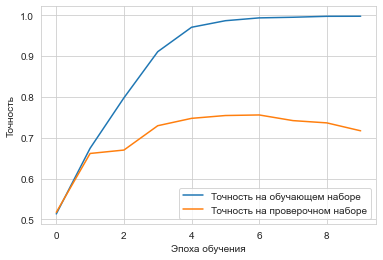

In [21]:
plot_history_nn(history)

In [22]:
y_pred = simple_model.predict(X_val)

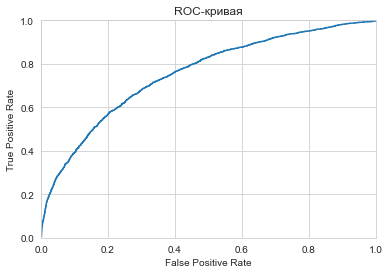

ROC-AUC Score: 0.7542665919529642


In [23]:
plot_roc_curve(y_pred, y_val)

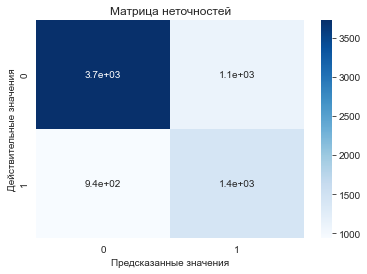

In [24]:
y_pred_int = [1 if pred[0] > 0.5 else 0 for pred in y_pred]  # так как предсказания в интервале 0 и 1, то будем считать, что 1 - больше 0.5, иначе - 0
plot_confusion_matrix(y_pred_int, y_val)

### Реккурентная сеть со слоем LSTM

In [25]:
model_lstm = Sequential()
model_lstm.add(Embedding(max_words, 128))
model_lstm.add(LSTM(32, recurrent_dropout = 0.2))
model_lstm.add(Dense(1, activation="sigmoid"))

model_lstm.compile(optimizer='rmsprop',  loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         12800000  
                                                                 
 lstm (LSTM)                 (None, 32)                20608     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,820,641
Trainable params: 12,820,641
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model_lstm.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1)

Epoch 1/10
51/51 [==============================] - 64s 1s/step - loss: 0.6073 - accuracy: 0.6671 - val_loss: 0.6039 - val_accuracy: 0.6338
Epoch 2/10
51/51 [==============================] - 62s 1s/step - loss: 0.3911 - accuracy: 0.8313 - val_loss: 0.4815 - val_accuracy: 0.7725
Epoch 3/10
51/51 [==============================] - 62s 1s/step - loss: 0.2085 - accuracy: 0.9479 - val_loss: 0.4100 - val_accuracy: 0.8447
Epoch 4/10
51/51 [==============================] - 61s 1s/step - loss: 0.1065 - accuracy: 0.9732 - val_loss: 0.4378 - val_accuracy: 0.8460
Epoch 5/10
51/51 [==============================] - 62s 1s/step - loss: 0.0565 - accuracy: 0.9863 - val_loss: 0.4604 - val_accuracy: 0.8599
Epoch 6/10
51/51 [==============================] - 61s 1s/step - loss: 0.0326 - accuracy: 0.9911 - val_loss: 0.4810 - val_accuracy: 0.8571
Epoch 7/10
51/51 [==============================] - 62s 1s/step - loss: 0.0216 - accuracy: 0.9941 - val_loss: 0.5375 - val_accuracy: 0.8419
Epoch 8/10
51/51 [==

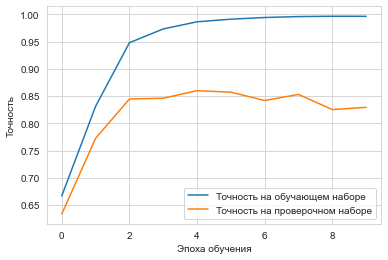

In [28]:
plot_history_nn(history)

In [29]:
y_pred = model_lstm.predict(X_val)

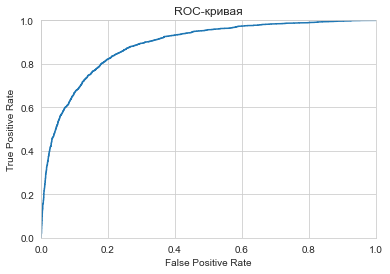

ROC-AUC Score: 0.8877520725678216


In [30]:
plot_roc_curve(y_pred, y_val)

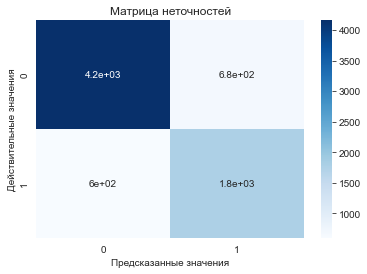

In [31]:
y_pred_int = [1 if pred[0] > 0.5 else 0 for pred in y_pred]  # так как предсказания в интервале 0 и 1, то будем считать, что 1 - больше 0.5, иначе - 0
plot_confusion_matrix(y_pred_int, y_val)

### Реккурентная сеть со слоем GRU

In [32]:
model_gru = Sequential()
model_gru.add(Embedding(max_words, 128))
model_gru.add(GRU(32, recurrent_dropout = 0.2))
model_gru.add(Dense(1, activation="sigmoid"))

model_gru.compile(optimizer='rmsprop',  loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         12800000  
                                                                 
 gru (GRU)                   (None, 32)                15552     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,815,585
Trainable params: 12,815,585
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model_gru.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1)

Epoch 1/10
51/51 [==============================] - 48s 904ms/step - loss: 0.6020 - accuracy: 0.6768 - val_loss: 0.5422 - val_accuracy: 0.7393
Epoch 2/10
51/51 [==============================] - 47s 918ms/step - loss: 0.3169 - accuracy: 0.8958 - val_loss: 0.4446 - val_accuracy: 0.8280
Epoch 3/10
51/51 [==============================] - 46s 911ms/step - loss: 0.1515 - accuracy: 0.9611 - val_loss: 0.4144 - val_accuracy: 0.8294
Epoch 4/10
51/51 [==============================] - 47s 919ms/step - loss: 0.0748 - accuracy: 0.9807 - val_loss: 0.4613 - val_accuracy: 0.8447
Epoch 5/10
51/51 [==============================] - 47s 914ms/step - loss: 0.0369 - accuracy: 0.9900 - val_loss: 0.5067 - val_accuracy: 0.8419
Epoch 6/10
51/51 [==============================] - 47s 912ms/step - loss: 0.0212 - accuracy: 0.9941 - val_loss: 0.9164 - val_accuracy: 0.8114
Epoch 7/10
51/51 [==============================] - 46s 911ms/step - loss: 0.0140 - accuracy: 0.9955 - val_loss: 0.6393 - val_accuracy: 0.8197

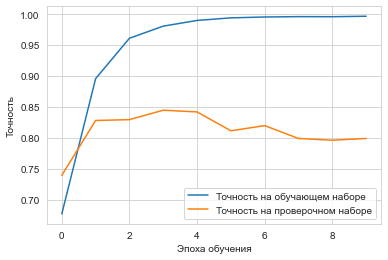

In [35]:
plot_history_nn(history)

In [36]:
y_pred = model_gru.predict(X_val)

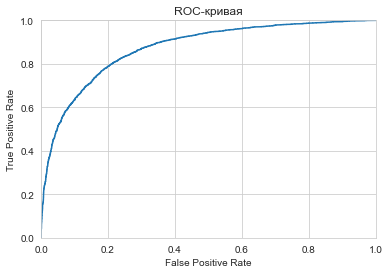

ROC-AUC Score: 0.8733578308404863


In [37]:
plot_roc_curve(y_pred, y_val)

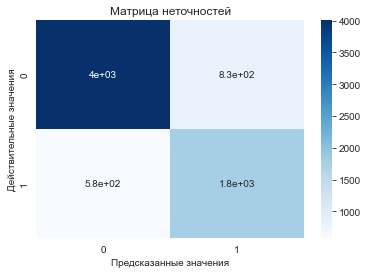

In [38]:
y_pred_int = [1 if pred[0] > 0.5 else 0 for pred in y_pred]  # так как предсказания в интервале 0 и 1, то будем считать, что 1 - больше 0.5, иначе - 0
plot_confusion_matrix(y_pred_int, y_val)

## Примеры

In [89]:
sample_data = train_data.sample(10)
X_sample = sample_data["comment"]
X_sample = pad_sequences(tokenizer.texts_to_sequences(X_sample))

In [90]:
y_simple_rnn = simple_model.predict(X_sample)
y_gru = model_gru.predict(X_sample)
y_lstm = model_lstm.predict(X_sample)

In [91]:
data = {
    "comment": sample_data["comment"].to_list(),
    "true_prediction": sample_data["toxic"].to_list(),
    "simple_rnn_prediction": [1  if value[0] > 0.5 else 0 for value in y_simple_rnn],
    "gru_prediction": [1  if value[0] > 0.5 else 0 for value in y_gru],
    "lstm_prediction": [1  if value[0] > 0.5 else 0 for value in y_lstm],
}

In [92]:
pd.DataFrame(data)

,comment,true_prediction,simple_rnn_prediction,gru_prediction,lstm_prediction
0,статье говорится хорош управлении вс упр рлось...,0.0,0,0,0
1,это правила работы документами сотрудник захоч...,0.0,0,0,0
2,почему бцж появляется шрамик,0.0,0,0,0
3,посмотрите одета это любому якутске происходило,0.0,0,0,0
4,ивашка простоквашкой,1.0,0,1,1
5,это эрефия метода сделать говно запретить бону...,1.0,1,1,1
6,честно говоря базовые потребности полностью по...,0.0,0,0,0
7,жалко р ближайшие несколько лет кредиты брать ...,0.0,0,0,0
8,выявлен каким анализам случайно рентгену ежего...,0.0,0,0,0
9,говорит регионы развиваются работа достойная з...,0.0,0,0,0
